# Tree SHAP Example

In [1]:
!pip install shap

     |████████████████████████████████| 276kB 9.5MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=4a42682c0e55a378d0bf70653af43ac759c6b61ccace796626fa20bbfb02fe27
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
import math
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Download Data from UCI link

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2020-03-26 10:23:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘default of credit card clients.xls’

default of credit c 100%[===================>]   5.28M  4.00MB/s    in 1.3s    

2020-03-26 10:23:34 (4.00 MB/s) - ‘default of credit card clients.xls’ saved [5539328/5539328]



In [0]:
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'default payment next month'] + ['PAY_'+str(x) for x in [0, 2, 3, 4, 5, 6]]
int_vars = ['AGE']
float_vars = ['LIMIT_BAL'] + ['BILL_AMT'+str(x) for x in range(1, 7)] + ['PAY_AMT'+str(x) for x in range(1, 7)]
dtypes = {col : 'category' for col in cat_vars}
for col in int_vars:
    dtypes[col] = 'int32'
for col in float_vars:
    dtypes[col] = 'float32'

In [5]:
data = pd.read_excel("/content/default of credit card clients.xls",
                     sheet_name='Data', dtype=dtypes, skiprows=1)
data.drop(columns= ['ID'], inplace= True)
print(f'Data shape: {data.shape}')
data.iloc[:5, :]

Data shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


#### Plotting Categorical Data


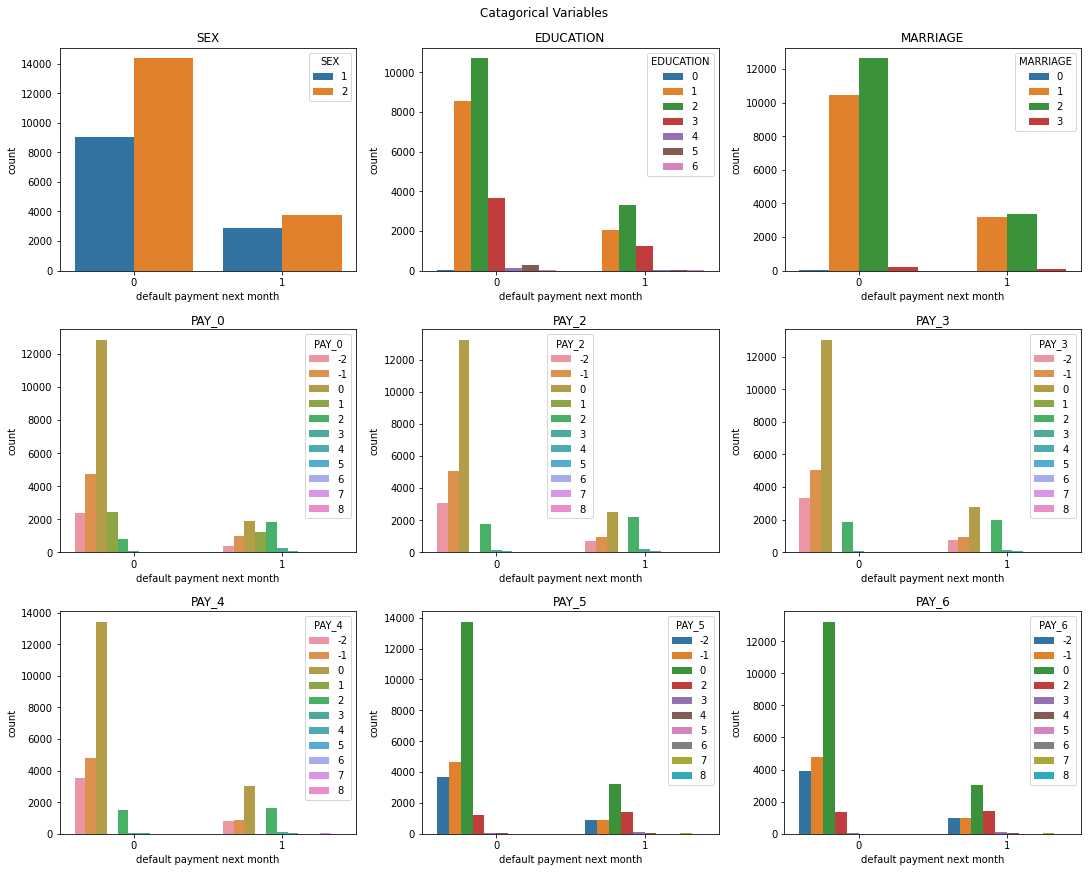

In [6]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


cat_vars = [var for var in cat_vars if var !=  'default payment next month']
ncols = 3
nrows = int(math.ceil(len(cat_vars)/ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), constrained_layout=True)
axs = trim_axs(axs, len(cat_vars))
f.suptitle('Catagorical Variables')
for ax, var in zip(axs, cat_vars):
    sns.countplot(data['default payment next month'], hue=data[var], ax=ax)
    ax.set_title(var)

#### Plotting Numerical Variables

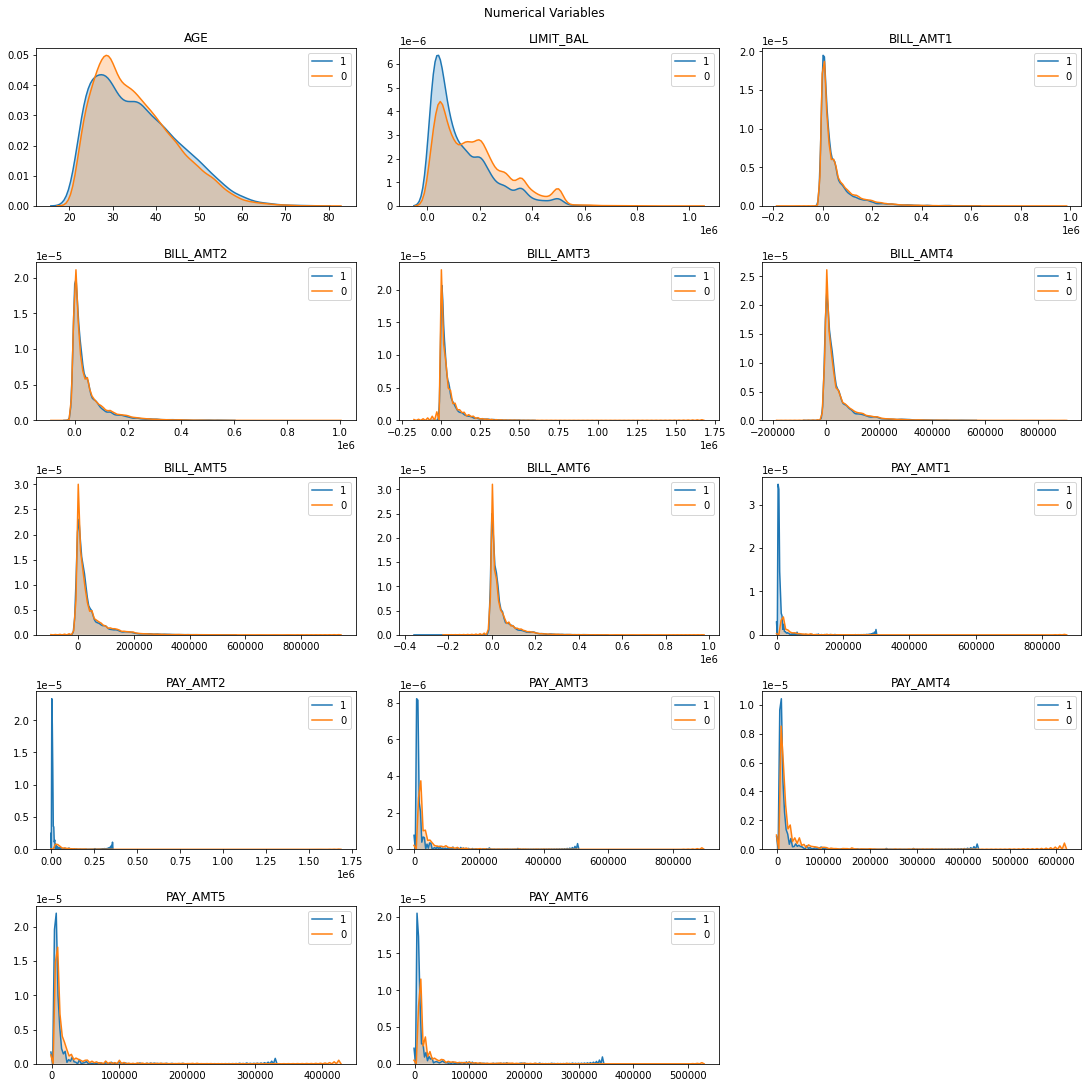

In [7]:
num_vars = int_vars + float_vars

ncols = 3
nrows = int(math.ceil(len(num_vars)/ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), constrained_layout=True)
axs = trim_axs(axs, len(num_vars))
f.suptitle('Numerical Variables')
for ax, var in zip(axs, num_vars):
    for val in data['default payment next month'].unique():
        sns.kdeplot(data.loc[data['default payment next month'] == val, var], shade=True, ax=ax, label=val);
    ax.set_title(var)

PAY_* columns have values ranging from -2 to 8. We add 3 to these values to make the range to 1 to 11 as lightgbm considers all negative values as missing values.

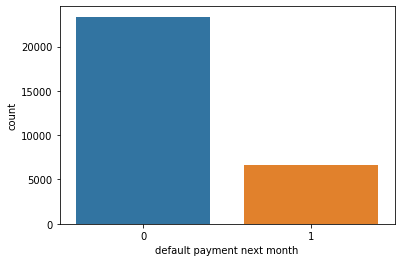

In [8]:
# Distribution of the Target variable.
sns.countplot(data['default payment next month']);

In [9]:
for col in ['PAY_'+str(x) for x in [0, 2, 3, 4, 5, 6]]:
    data[col] = (data[col].astype('int') + 3).astype('category')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000.0,2,2,1,24,5,5,2,2,1,1,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,2,5,3,3,3,5,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,3,3,3,3,3,3,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,3,3,3,3,3,3,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,2,3,2,3,3,3,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [10]:
y = data['default payment next month']
data.drop(columns = ['default payment next month'], inplace=True)
y.value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify = y)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
del data, y

X_train: (22500, 23), y_train: (22500,), X_test: (7500, 23), y_test: (7500,)


## Baseline LGB Model

In [0]:
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')

In [0]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_cat_to_onehot': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 100
}

In [14]:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=100,
                verbose_eval=100,
                valid_sets=[dtest, dtrain],  # eval training data
                )

[100]	training's auc: 0.844776	valid_0's auc: 0.781654


In [15]:
y_pred = gbm.predict(X_test)
print(f'AUC ROC for the baseline model: {roc_auc_score(y_test, y_pred)}')

AUC ROC for the baseline model: 0.7816540575605154


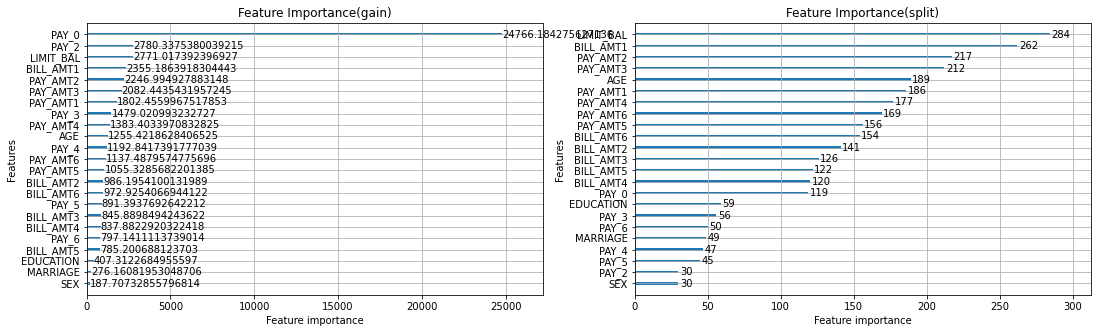

In [16]:
f, axs = plt.subplots(1, 2, figsize=(18, 5))
lgb.plot_importance(gbm, importance_type='gain', title='Feature Importance(gain)', ax=axs[0]);
lgb.plot_importance(gbm, importance_type='split', title='Feature Importance(split)', ax=axs[1]);

## Define Configuration Space for HyperOpt

In [17]:
#Use https://www.medcalc.org/manual/probability_distribution_functions.php to visualize the probability distributions.
space4lgb = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.5),
    'num_leaves': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('num_leaves', 4.5, 1, 1), 2)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'feature_fraction_bynode': hp.uniform('feature_fraction_bynode', 0.5, 1),
    'min_data_in_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_data_in_leaf', 4.5, 1, 1), 3)),
    'max_cat_to_onehot': pyll.scope.int(hp.quniform('max_cat_to_onehot', 4, 10, 1)),
    'lambda_l1': hp.lognormal('lambda_l1', 3, 2),
    'lambda_l2': hp.lognormal('lambda_l2', 3, 2),
    'max_bin': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('max_bin', 6.5, 1, 1), 10)), 
}
pyll.stochastic.sample(space4lgb)

{'bagging_fraction': 0.793567348124342,
 'feature_fraction': 0.9413241761825695,
 'feature_fraction_bynode': 0.6368949161232849,
 'lambda_l1': 68.52956078037946,
 'lambda_l2': 340.0734453298483,
 'learning_rate': 0.38047689520079847,
 'max_bin': 1290,
 'max_cat_to_onehot': 7,
 'min_data_in_leaf': 205,
 'num_leaves': 191}

In [0]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'num_boost_round': 100,
                  'metric': 'auc',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100
                  }

In [0]:
# Define the objective function for hyperopt
def hyperopt_lgb_train(params):
    params = {**default_params, **params}
    num_boost_round = params.pop('num_boost_round')
    valid_sets = params.pop('valid_sets')
    bst = lgb.train(params, dtrain, num_boost_round, valid_sets = valid_sets)
    return_dict = {'loss': -roc_auc_score(y_test, bst.predict(X_test)),
                   'status': STATUS_OK
                   }
    print(return_dict)
    return return_dict

In [20]:
#Test the objective function:
hyperopt_lgb_train(pyll.stochastic.sample(space4lgb))

{'loss': -0.7648505157623372, 'status': 'ok'}


{'loss': -0.7648505157623372, 'status': 'ok'}

In [0]:
trials = Trials()
best = fmin(hyperopt_lgb_train, space4lgb, algo=tpe.suggest, max_evals=3000, trials=trials)

{'loss': -0.5405549657856031, 'status': 'ok'}
{'loss': -0.6805143929151654, 'status': 'ok'}
{'loss': -0.7774913033441246, 'status': 'ok'}
{'loss': -0.7671883886215576, 'status': 'ok'}
{'loss': -0.7781873144456279, 'status': 'ok'}
{'loss': -0.7642810755876622, 'status': 'ok'}
{'loss': -0.7723846076130993, 'status': 'ok'}
{'loss': -0.7455868644454786, 'status': 'ok'}
{'loss': -0.7633553483156572, 'status': 'ok'}
{'loss': -0.7748874922228279, 'status': 'ok'}
{'loss': -0.7621272542963169, 'status': 'ok'}
{'loss': -0.7771384733410049, 'status': 'ok'}
{'loss': -0.7306009286271032, 'status': 'ok'}
{'loss': -0.7776437250798975, 'status': 'ok'}
{'loss': -0.7645336498586874, 'status': 'ok'}
{'loss': -0.7785289475913806, 'status': 'ok'}
{'loss': -0.757453211325771, 'status': 'ok'}
{'loss': -0.7763659417810888, 'status': 'ok'}
{'loss': -0.7670325097915744, 'status': 'ok'}
{'loss': -0.761989331716858, 'status': 'ok'}
{'loss': -0.7580217227288671, 'status': 'ok'}
{'loss': -0.770235378581227, 'status

In [21]:
best = {
    'bagging_fraction': 0.9503770158879287,
    'feature_fraction': 0.5857131468206892,
    'feature_fraction_bynode': 0.9120554269421401,
    'lambda_l1': 1.4689729868481995,
    'lambda_l2': 0.15467766956237552,
    'learning_rate': 0.10877675624568696,
    'max_bin': 75.0,
    'max_cat_to_onehot': 6.0,
    'min_data_in_leaf': 43.0,
    'num_leaves': 9.0}
space_eval(space4lgb, best)

{'bagging_fraction': 0.9503770158879287,
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 43,
 'num_leaves': 9}

In [22]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'num_boost_round': 100,
                  'metric': 'auc',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100
                  }
params = {**default_params, **space_eval(space4lgb, best)}
del params['valid_sets'], params['num_boost_round']
params

{'bagging_fraction': 0.9503770158879287,
 'bagging_seed': 100,
 'boosting_type': 'gbdt',
 'categorical_feature': 'auto',
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'metric': 'auc',
 'min_data_in_leaf': 43,
 'num_leaves': 9,
 'objective': 'binary',
 'seed': 100,
 'verbose': 0}

In [23]:
## Retraining the lgb model with best parameters:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                verbose_eval=10,
                valid_names=['eval', 'train'],
                valid_sets=[dtest, dtrain],  # eval training data
                early_stopping_rounds = 50
                )

Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.78112	eval's auc: 0.766995
[20]	train's auc: 0.788647	eval's auc: 0.775061
[30]	train's auc: 0.793998	eval's auc: 0.778502
[40]	train's auc: 0.798772	eval's auc: 0.780796
[50]	train's auc: 0.802151	eval's auc: 0.782068
[60]	train's auc: 0.805184	eval's auc: 0.782839
[70]	train's auc: 0.807801	eval's auc: 0.783338
[80]	train's auc: 0.810725	eval's auc: 0.783029
[90]	train's auc: 0.813173	eval's auc: 0.783548
[100]	train's auc: 0.815834	eval's auc: 0.784033
[110]	train's auc: 0.817848	eval's auc: 0.784344
[120]	train's auc: 0.820566	eval's auc: 0.783647
[130]	train's auc: 0.822783	eval's auc: 0.783162
[140]	train's auc: 0.824801	eval's auc: 0.782768
[150]	train's auc: 0.827558	eval's auc: 0.782625
[160]	train's auc: 0.829573	eval's auc: 0.78229
Early stopping, best iteration is:
[110]	train's auc: 0.817848	eval's auc: 0.784344


In [24]:
y_pred = gbm.predict(X_test)
print(y_pred[:5])
print(y_pred.shape)

[0.4327646  0.3839298  0.2004391  0.44863794 0.31501921]
(7500,)


Let's create a new dataframe for X_test with integer-coded categorical values replaced with the respective categories so that SHAP plots will be more intuitive. We get the details of the category levels from [UCI website](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). Remember that we added 3 to all PAY_* variables. Also we use "Unk_*" for levels not defined in the UCI site.

In [0]:
X_test_disp = X_test.copy()
X_test_disp.SEX = X_test_disp.SEX.map({1: 'M', 2: 'F'})
X_test_disp.EDUCATION = X_test_disp.EDUCATION.map({1: 'Grad School', 2: 'University', 3: 'High School', 4: 'Others', 5: 'Unk_5', 6: 'Unk_6', 0: 'Unk_0'})
X_test_disp.MARRIAGE = X_test_disp.MARRIAGE.map({1: 'Married', 2: 'Single', 3: 'Others', 0: 'Unk_0'})
for var in ['PAY_'+str(x) for x in [0, 2, 3, 4, 5, 6]]:
    X_test_disp[var] = X_test_disp[var].map({2: 'Paid', 4: '1 mnth', 5: '2 mnths', 6: '3 mnths', 7: '4 mnths', 8: '5 mnths', 9: '6 mnths', 
                                             10: '7 mnths', 11: '8 mnths', 3: 'Unk_0', 1: 'Unk_-1', 2: 'Unk_-2'})

## Computing SHAP Values

In [0]:
explainer = shap.TreeExplainer(model=gbm,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

In [0]:
shap_values = explainer.shap_values(X_test)

In [28]:
print(f'Shape of test dataset: {X_test.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')

Shape of test dataset: (7500, 23)
Type of shap_values: <class 'list'>. Length of the list: 2
Shape of shap_values: (2, 7500, 23)


### Explaining a single prediction
Let's expalin the model's prediction for first item in the testset.

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features=X_test_disp.iloc[0, :])

In [30]:
# Most GBM model predict logit in their leaf nodes hence Tree SHAP explains the logit values for the predictions made.
# Had the model been predicting the probability for a class, we Tree SHAP could expalin the probability values.
# See the explanation here: https://github.com/slundberg/shap/issues/367#issuecomment-508575308
print(f'True value for 0-th observation: {y_test.iloc[0]}')
print(f'Probability of default for 0-th observation: {y_pred[0]}')
print(f'Raw model prediction (logit) for 0-th observation: {gbm.predict(X_test, raw_score=True)[0]}')
print(f'Base value = mean logit (log-odds) over training data = {np.mean(gbm.predict(X_train, raw_score=True))}')

True value for 0-th observation: 1
Probability of default for 0-th observation: 0.4327646040616354
Raw model prediction (logit) for 0-th observation: -0.27058043736125065
Base value = mean logit (log-odds) over training data = -1.5384274035468193


In [31]:
print(f'Base value is stored as an attribute of the explainer object: {explainer.expected_value}')

Base value is stored as an attribute of the explainer object: [1.53842740354682, -1.53842740354682]


### Explaining the prediction for first 100 records in testset.

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], features=X_test_disp.iloc[:100, :])

### SHAP Summary Plots

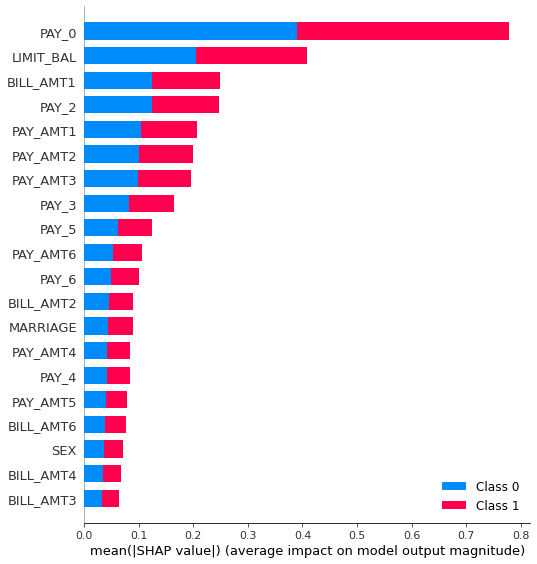

In [33]:
shap.summary_plot(shap_values, features=X_test_disp)

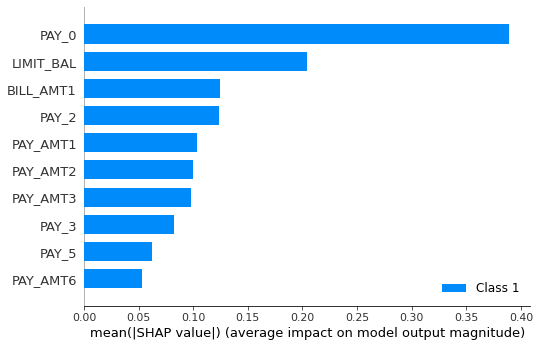

In [34]:
shap.summary_plot(shap_values, features=X_test_disp, class_inds=[1], max_display=10)

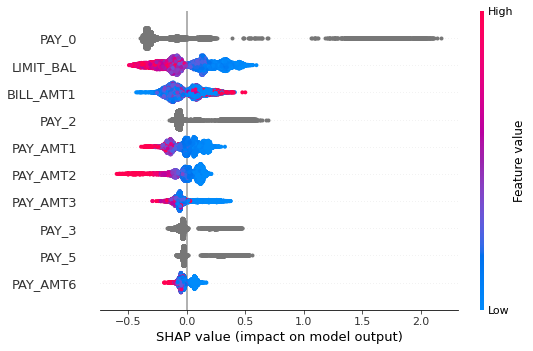

In [36]:
shap.summary_plot(shap_values[1], features=X_test_disp, max_display=10)

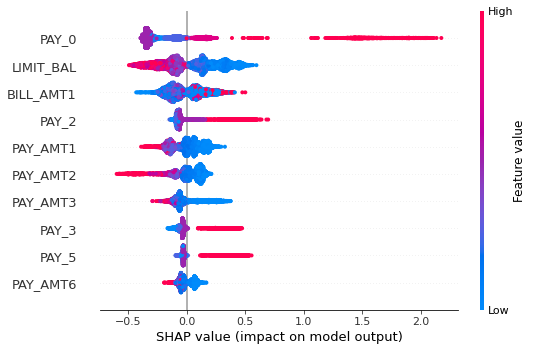

In [37]:
# Considering Pay_* as numeric variables:
shap.summary_plot(shap_values[1], features=X_test, max_display=10)

### SHAP Dependency Plots

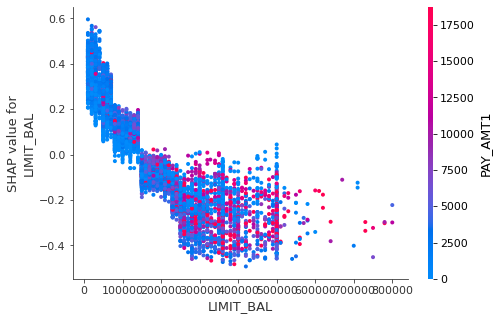

In [39]:
shap.dependence_plot('LIMIT_BAL', shap_values[1], features=X_test, display_features=X_test_disp, interaction_index='PAY_AMT1')

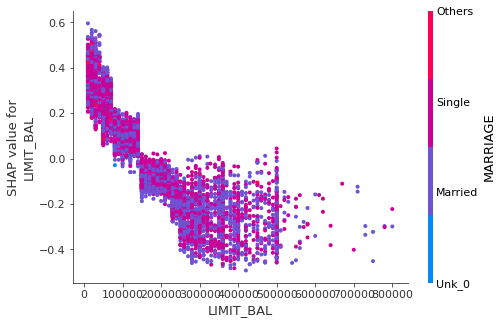

In [54]:
shap.dependence_plot('LIMIT_BAL', shap_values[1], features=X_test, display_features=X_test_disp, interaction_index='MARRIAGE')

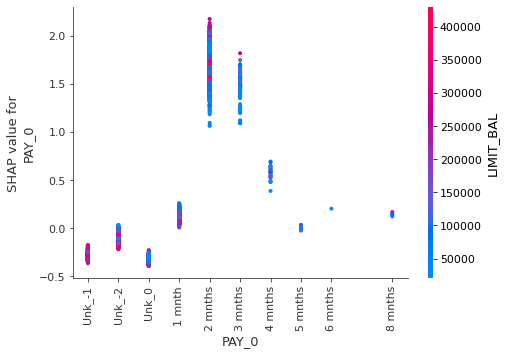

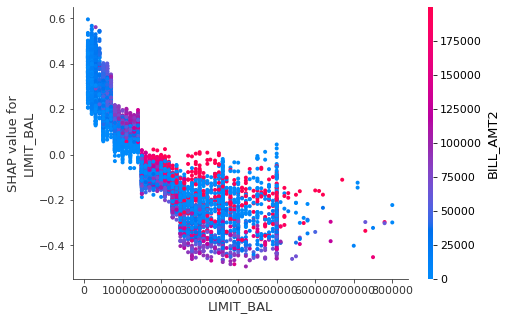

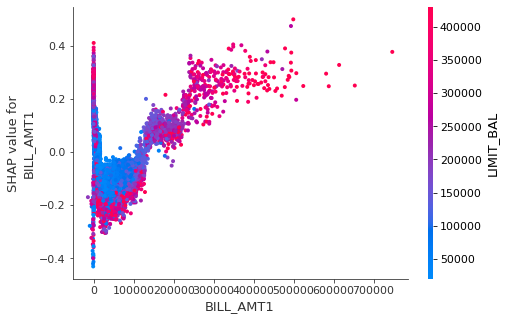

In [58]:
# Sort the features indexes by their importance in the model (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))
# make SHAP plots of the three most important features
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values[1], features=X_test, display_features=X_test_disp)